# Visualization and examplary class detection for Audiofiles

Part of Assignment 2 for CH-CASM-M, WS 25/26, Marius Lang, Danylo Markasian, Alisa Münsterberg

In [26]:
# import important libraries
import librosa
import numpy as np
import matplotlib.pyplot as pl
import random
import zipfile
import os
import glob
import torch
import IPython.display as ipd

Audiodata is extracted from a folder "test_files", which can either be provided as a .zip-file "test_files.zip", which is extracted into folder "test_files", or directly in that folder. Audiodata must be provided as ".wav"-files, which are added to the array "audio_input for further use.

In [27]:
# load .wav-files as input and play it
# first: add the "test-files"-directory to the sample_data of the notebook, or change the path to lead to it in your configuration

# if there is a zip-file "test_files.zip", unzip it:
if os.path.isfile('test_files.zip'):
  with zipfile.ZipFile('test_files.zip', 'r') as zip:
    zip.extractall('.')
    print('Files are extracted!')

# else if there is no directory with the same name
if not os.path.isdir('test_files'):
  print('No directory "test_files" detected, make sure to add the zipped directory it to "sample data" first!')

else:
  audio_input = []
  files = sorted(glob.glob(os.path.join('test_files', '*.wav'))) #get all the .wav-files in test_files
  for i in files:
    audio_input.append(i)
    print(i)



Files are extracted!
test_files\test0.wav
test_files\test1.wav
test_files\test2.wav
test_files\test3.wav
test_files\test4.wav
test_files\test5.wav
test_files\test6.wav
test_files\test7.wav
test_files\test8.wav


To predict the class of the example audio-files, we first load one of the different models ('cnn': WakeWordCNN,'crnn': CRNN_with_MBConv,'crnn_temporal': CRNN_TemporalConv) and load trained weights by choosing a trained state from "trained_models". You can change the used model by changing the value of "model_name" to either "cnn", "crnn" or "crnn_temporal", and the pre-traines weights used by changing the path in "model.load_state_dict".

In [28]:
# load trained model
from model.model_registry import get_model
from utils.get_device import get_device
import json

selected_model = 'experiments/wakeword_model_20251212_171319'

# Get model architecture from config
if not os.path.isdir(selected_model):
    print('Select a valid pre-trained model and add the name of the folder as "selected_model".')

else:
    with open(f'{selected_model}/config.json', 'r') as f:
    # Parsing the JSON file into a Python dictionary
        config = json.load(f)
    model_name = config.get('model_architecture')  
    input_shape =  config.get('input_shape')
    print('Chosen model architecture : ', model_name, 'and input shape: ', input_shape)  

    model = get_model(model_name, input_shape, 2).to(get_device())#2 = number of classes #todo: input-shape
    print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

#Change path here to try the model with different pre-trained weights!
model.load_state_dict(torch.load(f'{selected_model}/model.pt', map_location='cpu',weights_only=True))
model.eval() #put the model into evaluation mode

Chosen model architecture :  cnn and input shape:  [1, 40, 100]
Model parameters: 137,122


WakeWordCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1920, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

For easier use, we further define the function display_plotted_spectogram, which prints the spectogram as a plot, containing code from the same notebook CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, provided by Prof. Dr. Jakob Abeßer 

In [ ]:
#Define function to display a spectogram as a plot
from utils.audio_processing import compute_mel_spectrogram

def display_plotted_spectogram(input_file):
  # code from CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, author: Prof. Dr. Jakob Abeßer
    print(config)
    sr = config['config']['SR']
    n_mels = config['config']['N_MELS']
    n_fft = config['config']['N_FFT']
    hop = config['config']['HOP']
    segment_frames = config['config']['SEGMENT_FRAMES']

    mel_spec = compute_mel_spectrogram(input_file, sr, n_fft, hop, n_mels)

    print("\n\nShape of Mel-spectrogram for audiofile", input_file, ":", mel_spec.shape) # to compare shape of spectogram against expectation

    pl.figure()
    pl.imshow(mel_spec, origin="lower", aspect="auto", interpolation="None")#origin: where is 0:0 in coordinate system?
    pl.ylabel('Mel frequency bands')
    pl.xlabel('Time frames')
    pl.show()
  #black in the spectogram is silence; zero-padding to achieve sequences of equal length

Through changing the value of the variable file_amount in the next code block, the user can decide how many of the files should be visualized (and for how many the model shall make predictions later). With value "1", a single random file is chosen, for all higher values the amount of files is chosen in the order of the audio_input-array. If the number exceeds that of the existing files, we default to simply choosing all existing files.

In [63]:
#First select the amount of files to be visualized
print("Would you like to visualize, play and predict the class of only one of the example files or all of them?")
print('Change the value of the variable "file_amount" to determine how many files you would like to choose.\n')

# set file_ amount to 1 to display one random sample, custom number to display a number od your choosing or len(audio.input)-1 to display all example files
file_amount = 2
print('You have set the file_amount to:', file_amount,'. If you would like to choose a different amount of files, change the value of the variable first, then run this code-section again.')
#select random example now to keep it the same

Would you like to visualize, play and predict the class of only one of the example files or all of them?
Change the value of the variable "file_amount" to determine how many files you would like to choose.

You have set the file_amount to: 2 . If you would like to choose a different amount of files, change the value of the variable first, then run this code-section again.


The next codeblock provides a player for an audiofile (again using code from CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, author: Prof. Dr. Jakob Abeßer) as well as visualiation as a spectogram.




 Play to determine correct class for file test_files\test0.wav :


{'timestamp': '20251212_171319', 'model_architecture': 'cnn', 'model_parameters': 137122, 'final_accuracy': 0.9962322253419075, 'epochs_trained': 51, 'input_shape': [1, 40, 100], 'num_classes': 2, 'config': {'SR': 16000, 'N_MELS': 40, 'N_FFT': 400, 'HOP': 160, 'SEGMENT_FRAMES': 100, 'SEGMENTS_PER_FILE': 10, 'DATA_DIR': 'data', 'CLASSES': ['non_wakeword', 'wakeword_augmented'], 'EPOCHS': 200, 'EARLY_STOPPING_PATIENCE': 15, 'EARLY_STOPPING_MIN_DELTA': 0.0001, 'WAKEWORD_RATIO': 0.25}}


Shape of Mel-spectrogram for audiofile test_files\test0.wav : (40, 201)


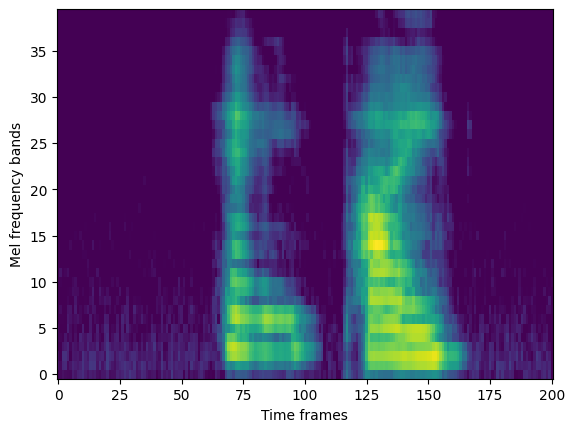



 Play to determine correct class for file test_files\test1.wav :


{'timestamp': '20251212_171319', 'model_architecture': 'cnn', 'model_parameters': 137122, 'final_accuracy': 0.9962322253419075, 'epochs_trained': 51, 'input_shape': [1, 40, 100], 'num_classes': 2, 'config': {'SR': 16000, 'N_MELS': 40, 'N_FFT': 400, 'HOP': 160, 'SEGMENT_FRAMES': 100, 'SEGMENTS_PER_FILE': 10, 'DATA_DIR': 'data', 'CLASSES': ['non_wakeword', 'wakeword_augmented'], 'EPOCHS': 200, 'EARLY_STOPPING_PATIENCE': 15, 'EARLY_STOPPING_MIN_DELTA': 0.0001, 'WAKEWORD_RATIO': 0.25}}


Shape of Mel-spectrogram for audiofile test_files\test1.wav : (40, 196)


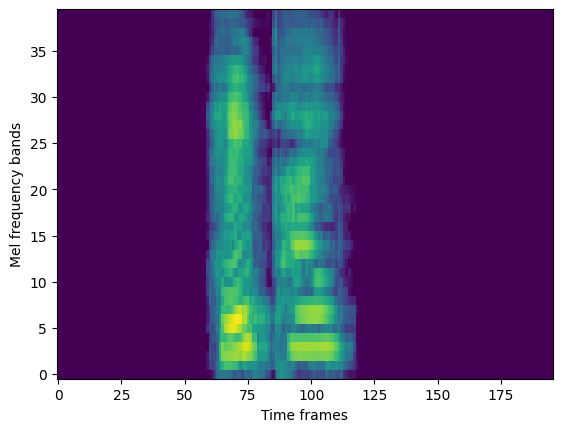

In [64]:
#Play a sample file and visualize it

example_index = random.randint(0,len(audio_input)-1) #choose random index in dataset range
example_input = audio_input[example_index] #choose file at the random index as example

if file_amount == 0:
  print('Please choose the amount of files to visualize - your choice of "0" files does not work.')

elif file_amount == 1:
  example_index = random.randint(0,len(audio_input)-1) #choose random index in dataset range
  example_input = audio_input[example_index] #choose file at the random index as example

  print("Play the example file to determine correct class for file " + example_input +" :")
  # code from CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, author: Prof. Dr. Jakob Abeßer
  x, fs = librosa.load(example_input)
  ipd.display(ipd.Audio(data=x, rate=fs)) #visualizes a player for the input file

  # visualize the input file as a spectogram
  display_plotted_spectogram(example_input)

else:
  if file_amount >= len(audio_input)-1:
    file_amount = len(audio_input)-1
    print('There are less files than you wanted to select, all available files will be displayed instead. Available files: ' + str(file_amount))

  i = 0
  while i <= file_amount-1:
    audiofile = audio_input[i]
    print('\n\n Play to determine correct class for file ' + audiofile + ' :')
    # code from CH-CASM-M-04-Deep-Learning-Seminar-1.ipynb, author: Prof. Dr. Jakob Abeßer
    audio, fs = librosa.load(audiofile)
    ipd.display(ipd.Audio(data=audio, rate=fs)) #visualizes a player for the input file
    display_plotted_spectogram(audiofile)
    i += 1

Predict the class of the chosen example-file(s) and print it.

In [66]:
# predict class wakeword/ non-wakeword for input-files
from detection.pytorch.pytorch_inference import preprocess_audio

class_predictions = []

if file_amount == 1:
  tensor = preprocess_audio(example_input, config['config'])
  print('Shape of segments: ', tensor.shape)
  with torch.no_grad():
    out = model(tensor)
    print(out) 
    probability = torch.softmax(out,1)
    probability_numpy = probability.cpu().numpy()
    wakeword_prob = np.max(probability_numpy[:,1])
    predictions = np.argmax(probability_numpy,1)
    wakeword_frames = np.sum(predictions == 1)
    print('Predicted wakeword-probability: ', wakeword_prob, 'with', wakeword_frames ,'frames being predicted as wakeword.')
    ratio = wakeword_frames/len(predictions)
    class_predictions.append(ratio)
    if ratio < 0.2:
      print('The predicted class is "non_wakeword", predicted ratio is:', ratio)
    else:
      print('The predicted class for the example-file: "',example_input, 'is: "wakeword", predicted ratio is:', ratio)  

else:
  i = 0
  while i <= file_amount-1:
    tensor = preprocess_audio(example_input, config['config'])
    print('Shape of segments: ', tensor.shape)
    with torch.no_grad():
      out = model(tensor)
      print(out) 
      probability = torch.softmax(out,1)
      probability_numpy = probability.cpu().numpy()
      wakeword_prob = np.max(probability_numpy[:,1])
      predictions = np.argmax(probability_numpy,1)
      wakeword_frames = np.sum(predictions == 1)
      print('Predicted wakeword-probability: ', wakeword_prob, 'with', wakeword_frames ,'frames being predicted as wakeword.')
      ratio = wakeword_frames/len(predictions)
      class_predictions.append(ratio)
      if ratio < 0.2:
       print('The predicted class is "non_wakeword", predicted ratio is:', ratio)
      else:
        print('The predicted class for the example-file: "',example_input, 'is: "wakeword", predicted ratio is:', ratio)
    i += 1


Shape of segments:  torch.Size([10, 1, 40, 100])
tensor([[  67.4497,  -53.8308],
        [  19.6575,  -35.8852],
        [  16.0893,  -28.2102],
        [  38.0718,   -5.4654],
        [ 101.8158,  -69.6705],
        [  87.3150,  -53.9556],
        [  77.9992,  -77.2659],
        [  72.9924,  -72.6236],
        [  90.7209, -101.5249],
        [  87.6692,  -91.4710]])
Predicted wakeword-probability:  1.2359495e-19 with 0 frames being predicted as wakeword.
The predicted class is "non_wakeword", predicted ratio is: 0.0
Shape of segments:  torch.Size([10, 1, 40, 100])
tensor([[  67.4497,  -53.8308],
        [  19.6575,  -35.8852],
        [  16.0893,  -28.2102],
        [  38.0718,   -5.4654],
        [ 101.8158,  -69.6705],
        [  87.3150,  -53.9556],
        [  77.9992,  -77.2659],
        [  72.9924,  -72.6236],
        [  90.7209, -101.5249],
        [  87.6692,  -91.4710]])
Predicted wakeword-probability:  1.2359495e-19 with 0 frames being predicted as wakeword.
The predicted cla